In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

In [209]:
def mesher2D(nrows,ncols,length,height,deg=1):
    '''
    This is a function for creating a mesh of 2D rectilinear elements. It assumes the points are laid out in a grid.
    Currently, only linear elements are supported.

    Inputs
    ------
    nrows: integer. Number of elements in a row
    ncols: integer. Number of elements in a column
    length: float. Length of the domain
    height: float. Height of the domain

    Returns
    -------
    node_dict: dictionary. A multi-level dictionary with the global node numbers as the outer keys, and the inner dictionary
    for each global node containing the x and y coordinates of that node.
    
    elem_nodes: array. An array where each row is an element, counting left to right, bottom to top of the domain,
    and each entry for each element are the global node numbers, counting counter-clockwise from the upper right node.

    '''
    if nrows*ncols%2 != 0:
        root = np.sqrt(nrows*ncols)
        if root - int(root) > 0.0: # checks for a perfect square
            raise ValueError('Uneven grid detected.')
        # else:
        #     print('Square domain detected.')
    n_xnodes = ncols + 1
    n_ynodes = nrows + 1
    dx = length/ncols
    dy = height/nrows
    xnodes = np.arange(0,length+dx,dx)
    ynodes = np.arange(0,height+dy,dy)
    X,Y = np.meshgrid(xnodes,ynodes)
    if deg==1:
        nodes_per_elem=4
    elem_nodes = np.zeros((nrows*ncols,nodes_per_elem),dtype='int')
    # row = 0
    # for e in range(nrows*ncols):
    #     # print(e+row,e+1+row,e+nrows+1+row,e+nrows+2+row)
    #     elem_nodes[e] = e+nrows+2+row,e+nrows+1+row,e+row,e+1+row
    #     if (e%(ncols-1) == 0.0 and e!=0):
    #         row += 1
    for row in range(nrows):
        for col in range(ncols):
            elem_nodes[nrows*row+col] = n_xnodes*(row+1)+(col+1),n_xnodes*(row+1)+col,n_xnodes*row+col,n_xnodes*row+col+1
    node_dict = {}
    node_count = 0
    for i in range(nrows+1):
        for j in range(ncols+1):
            node_dict[node_count] = {'x':X[i,j],'y':Y[i,j]}
            node_count += 1
    return node_dict, elem_nodes

def retrieve_coords(node_dict,elem_nodes,eid):
    nodes = elem_nodes[eid]
    x = []
    y = []
    for node in nodes:
        xval = node_dict[node]['x']
        yval = node_dict[node]['y']
        x.append(xval)
        y.append(yval)
    coords = np.concatenate((x,y))
    return coords

def ref_square_basis(Xi,Eta):
    N1 = 0.25*(1+Xi)*(1+Eta)
    N2 = 0.25*(1-Xi)*(1+Eta)
    N3 = 0.25*(1-Xi)*(1-Eta)
    N4 = 0.25*(1+Xi)*(1-Eta)
    return [N1,N2,N3,N4]

def square_basis_derivs(Xi,Eta):
    dN1xi = 0.25*(1+Eta)
    dN2xi = -0.25*(1+Eta)
    dN3xi = -0.25*(1-Eta)
    dN4xi = 0.25*(1-Eta)
    dN1eta = 0.25*(1+Xi)
    dN2eta = 0.25*(1-Xi)
    dN3eta = -0.25*(1-Xi)
    dN4eta = -0.25*(1+Xi)
    return [dN1xi,dN2xi,dN3xi,dN4xi],[dN1eta,dN2eta,dN3eta,dN4eta]

def gaussian_points(npts=4):
    if npts == 4:
        xi = [np.sqrt(1/3),-np.sqrt(1/3),-np.sqrt(1/3),np.sqrt(1/3)]
        eta = [np.sqrt(1/3),np.sqrt(1/3),-np.sqrt(1/3),-np.sqrt(1/3)]
        w = [1.0,1.0,1.0,1.0]
    return xi,eta,w

def jacobian(dNxi,dNeta,coords):
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    dxdxi = sum([x_*dN for x_,dN in zip(x,dNxi)])
    dydxi = sum([y_*dN for y_,dN in zip(y,dNxi)])
    dxdeta = sum([x_*dN for x_,dN in zip(x,dNeta)])
    dydeta = sum([y_*dN for y_,dN in zip(y,dNeta)])
    return np.array([[dxdxi,dxdeta],[dydxi,dydeta]])

def K1(kcond,dNxi,dNeta,J):
    if isinstance(dNxi,list):
        dNxi = np.array([dNxi]).reshape(-1,1)
        dNeta = np.array([dNeta]).reshape(-1,1)
    if dNxi.ndim < 2:
        dNxi = dNxi.reshape(-1,1)
        dNeta = dNeta.reshape(-1,1)
    K = np.concatenate((dNxi,dNeta),axis=1)
    Jinv = np.linalg.inv(J)
    result = kcond*K@Jinv.T@Jinv@K.T*np.linalg.det(J)
    return result

def K2(hz,N,J):
    if isinstance(N,list):
        N = np.array(N).reshape(-1,1)
    return hz*N@N.T*np.linalg.det(J)

def dGamma(coords,dNxi,dNeta):
    x = np.array(coords[:len(coords)//2])
    y = np.array(coords[len(coords)//2:])
    if isinstance(dNxi,list):
        dNxi = np.array(dNxi)
        dNeta = np.array(dNeta)
    temp1 = (np.dot(dNxi,x))**2 + (np.dot(dNxi,y))**2
    dG1 = np.sqrt(temp1)
    temp2 = (np.dot(dNeta,x))**2 + (np.dot(dNeta,y))**2
    dG2 = np.sqrt(temp2)
    return [dG1, dG2]

def bcs(nelemsx,nelemsy,q):
    nx = nelemsx+1
    ny = nelemsy+1
    arr = np.zeros((nx,ny))
    arr[0,:] += q['bottom']
    arr[-1,:] += q['top']
    arr[:,-1] += q['right']
    arr2 = np.zeros((nx,ny))
    arr2[0,:] = 1
    arr2[-1,:] = 1
    arr2[:,-1] = 1

    return arr, arr2

def rhs_bcs(qarr,q,bcs_arr,dG,nodes):
    dGxi, dGeta = dG
    f = np.zeros(4)
    qarr = qarr.flatten()
    bcs_arr = bcs_arr.flatten()
    xi = [[np.sqrt(1/3),-np.sqrt(1/3)],
          [-1.0,-1.0],
          [-np.sqrt(1/3),np.sqrt(1/3)],
          [1.0,1.0]]
    eta = [[1.0,1.0],
           [np.sqrt(1/3),-np.sqrt(1/3)],
           [-1.0,-1.0],
           [-np.sqrt(1/3),np.sqrt(1/3)]]
    edges = ['top','left','bottom','right']
    for idx, (xx, ee, edge) in enumerate(zip(xi,eta,edges)):
        N1 = ref_square_basis(xx[0],ee[0])
        N2 = ref_square_basis(xx[1],ee[1])
        N1 = np.array(N1)
        N2 = np.array(N2)
        if idx == 0 or idx == 2:
            dg = dGxi
        else:
            dg = dGeta
        # print(nodes[idx],nodes[(idx+1)%4])
        if bcs_arr[nodes[idx]] + bcs_arr[nodes[(idx+1)%4]] >= 2:
            # q1 = qarr[nodes[idx]]
            # q2 = qarr[nodes[(idx+1)%4]]
            qedge = q[edge]
            # dTdn = q1*N1[idx] + q2*N2[(idx+1)%4]
            # dTdn1 = q1*N1[idx] + q2*N1[(idx+1)%4]
            # dTdn2 = q1*N2[idx] + q2*N2[(idx+1)%4]
            # dTdn = q1*(N1[idx]+N2[idx])
            val1 = np.array(N1)*qedge*dg
            val2 = np.array(N2)*qedge*dg
            f += val1
            f += val2
        else:
    return f


def rhs_conv(N,J,hz,Tinf):
    if isinstance(N,list):
        N = np.array(N)
    return hz*Tinf*N*np.linalg.det(J)



In [222]:
nelemsx = 20
nelemsy = 20
nelems = nelemsx*nelemsy
nnodes = (nelemsx+1)*(nelemsy+1)
L = 1.
H = 1.
x = np.linspace(0,L,nelemsx+1)
y = np.linspace(0,H,nelemsy+1)
X,Y = np.meshgrid(x,y)
t = 0.05
Twall = 80.
Tinf = 30.
kcond = 5.
hconv = 10.
q = {'top':-500,'right':-1000,'bottom':-1500,'left':0.0}
hz = 2*hconv/t
node_dict, elem_nodes = mesher2D(nelemsy,nelemsx,L,H,1)
qarr,bcs_arr = bcs(nelemsx,nelemsy,q)

In [223]:
K = np.zeros((nnodes,nnodes))
F = np.zeros(nnodes)
for elem in range(nelems):
    nodes = elem_nodes[elem]
    coords = retrieve_coords(node_dict,elem_nodes,elem)
    xcoords = coords[:len(coords)//2]
    ycoords = coords[len(coords)//2:]
    Xi, Eta, w = gaussian_points(4)
    ktemp1 = np.zeros((4,4))
    ktemp2 = np.zeros((4,4))
    ftemp1 = np.zeros(4)
    ftemp2 = np.zeros(4)
    for xi, eta in zip(Xi,Eta):
        N = ref_square_basis(xi,eta)
        dNxi,dNeta = square_basis_derivs(xi,eta)
        J = jacobian(dNxi,dNeta,coords)
        dg = dGamma(coords,dNxi,dNeta)
        k1 = K1(kcond,dNxi,dNeta,J)
        k2 = K2(hz,N,J)
        ktemp1 += k1*w
        ktemp2 += k2*w
        f1 = rhs_conv(N,J,hz,Tinf)
        ftemp1 += f1
    f2 = rhs_bcs(qarr,q,bcs_arr,dg,nodes)
    ftemp2 += f2
    for i,row in enumerate(nodes):
        F[row] += ftemp1[i]
        F[row] += ftemp2[i]
        for j,col in enumerate(nodes):
            K[row,col] += ktemp1[i,j]
            K[row,col] += ktemp2[i,j]
    for i in range(nnodes):
        if i%(nelemsx+1) == 0:
            K[i,i] = 1e8
            F[i] = Twall*1e8
    

Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope
Nope


In [224]:
F

array([ 8.0e+09, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01,
       -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01,
       -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01, -6.0e+01,
       -6.0e+01, -6.0e+01, -5.5e+01,  8.0e+09,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01, -3.5e+01,
        8.0e+09,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01, -3.5e+01,  8.0e+09,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,
        3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01, -3.5e+01,
        8.0e+09,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e+01,  3.0e

In [225]:
T = np.linalg.solve(K,F)

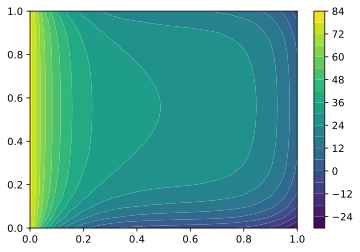

In [226]:
X,Y = np.meshgrid(np.linspace(0,L,nelemsx+1),np.linspace(0,H,nelemsy+1))
plt.contourf(X,Y,T.reshape(nelemsx+1,nelemsy+1),levels=20)
plt.colorbar()

In [227]:
T

array([ 80.00000184,  42.95810774,  24.90609871,  14.10543519,
         7.53838899,   3.47818961,   0.94345987,  -0.65519359,
        -1.67976901,  -2.35798521,  -2.83833625,  -3.22455206,
        -3.5988942 ,  -4.04010727,  -4.64019686,  -5.52372385,
        -6.87371564,  -8.96961071, -12.2451159 , -17.37796233,
       -25.43013836,  80.00000373,  53.74882046,  36.37806334,
        25.94205636,  19.50239625,  15.49938067,  12.99139929,
        11.40597184,  10.38816382,   9.71350476,   9.23506243,
         8.84988775,   8.47612108,   8.03522954,   7.43532116,
         6.55189697,   5.20196367,   3.10610173,  -0.16938519,
        -5.30222252, -13.35439579,  80.000004  ,  57.65051205,
        42.6898359 ,  33.0055717 ,  26.89513114,  23.04115839,
        20.60533825,  19.0562119 ,  18.05723315,  17.39256983,
        16.91953228,  16.53732348,  16.16520406,  15.72523649,
        15.12585054,  14.24272352,  12.89295968,  10.79719389,
         7.52176007,   2.38894924,  -5.66321601,  80.00